
`~/data/split`:

    BirdHome: 4221 images
    BirdRoaming: 1444 images
        
    Baseline accuracy: 74.5 %
    
`~/data/split-balanced` is 50/50

In [14]:
from itertools import product
from pathlib import Path

import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, ReLU, Activation, MaxPooling2D, Flatten
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
INPUT_SIZE = (224, 224, 3)
PATH = Path("~/data/split-balanced").expanduser()

In [29]:
model = Sequential()
model.add(Conv2D(64, (3, 3), 
                 input_shape=INPUT_SIZE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
activation_6 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 32)       

In [38]:
BATCH_SIZE = 64
RESCALE = 1/255
FEATUREWISE_CENTER = False  # Requires fit on a sample; do later

train_datagen = ImageDataGenerator(
    rescale=RESCALE,
#     featurewise_center=FEATUREWISE_CENTER,
#         shear_range=0.05,
#         zoom_range=0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True
)
# train_datagen.fit()

train_generator = train_datagen.flow_from_directory(
        PATH / "train",
        target_size=INPUT_SIZE[0:2],
        batch_size=BATCH_SIZE,
        class_mode="binary")

val_datagen = ImageDataGenerator(
    rescale=RESCALE,
#     featurewise_center=FEATUREWISE_CENTER,
)

val_generator = val_datagen.flow_from_directory(
    PATH / "cv",
    target_size=INPUT_SIZE[0:2],
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 1732 images belonging to 2 classes.
Found 578 images belonging to 2 classes.


In [39]:
class_ind = train_generator.class_indices
class_ind = {v: k for k, v in class_ind.items()}
class_ind

{0: 'BirdHome', 1: 'BirdRoaming'}

Hm, directly oppositie of what I said was positive and negative during split. Well, no matter.

In [40]:
batch_imgs, batch_labels = train_generator.next()

In [41]:
batch_imgs.shape

(64, 224, 224, 3)

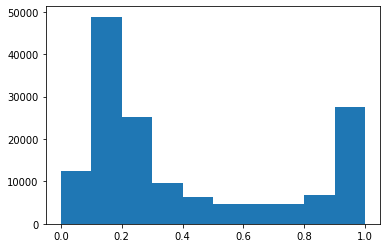

In [42]:
plt.hist(batch_imgs[0, :].ravel());

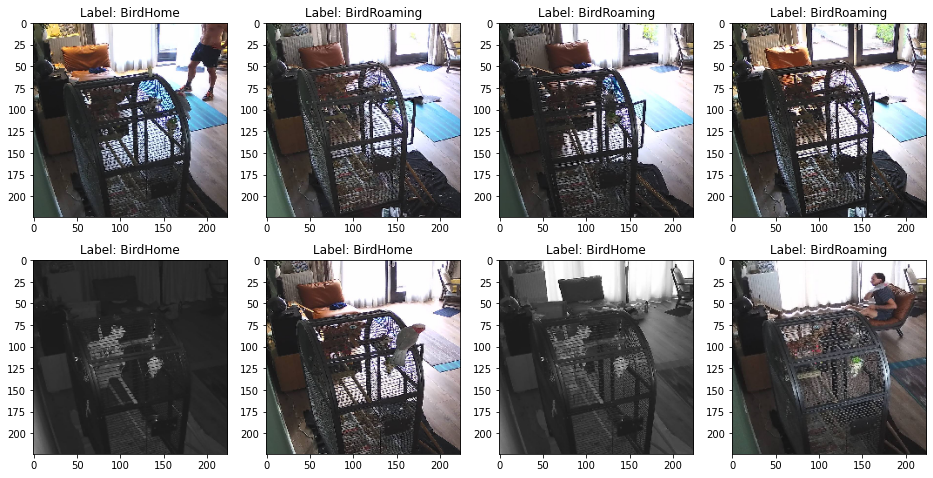

In [12]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for idx, ax in zip(range(8), axes.ravel()):
    ax.imshow(batch_imgs[idx, :])
    ax.set_title(f"Label: {class_ind[batch_labels[idx]]}")

Ok, sometimes it's very hard, even for me, to see the bird on on this resolution. Well, let's see what the model does.

In [43]:
model.fit_generator(
        train_generator,
        steps_per_epoch=866 // BATCH_SIZE,
        epochs=20,
        validation_data=val_generator,
        validation_steps=289 // BATCH_SIZE
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/20
13/13 [==============================] - 14s 1s/step - loss: 0.4287 - accuracy: 0.8125 - val_loss: 0.8671 - val_accuracy: 0.5547
Epoch 2/20
13/13 [==============================] - 14s 1s/step - loss: 0.3767 - accuracy: 0.8450 - val_loss: 1.0091 - val_accuracy: 0.5938
Epoch 3/20
13/13 [==============================] - 15s 1s/step - loss: 0.3120 - accuracy: 0.8702 - val_loss: 1.1158 - val_accuracy: 0.4453
Epoch 4/20
13/13 [==============================] - 15s 1s/step - loss: 0.3093 - accuracy: 0.8798 - val_loss: 1.0677 - val_accuracy: 0.3438
Epoch 5/20
13/13 [==============================] - 15s 1s/step - loss: 0.2684 - accuracy: 0.8731 - val_loss: 1.1559 - val_accuracy: 0.3828
Epoch 6/20
13/13 [==============================] - 15s 1s/step - loss: 0.2494 - accuracy: 0.8769 - val_loss: 1.0581 - val_accuracy: 0.5039
Epoch 7/20
13/13 [==============================] - 14s 1s/step - los

In [44]:
# model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=1,
# #     batch_size=BATCH_SIZE
# )

In [45]:
# model.save_weights('weights.h5')

# Metrics

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [55]:
def eval_model(model, gen, title):
    THR = .5
    y_hat_prob = model.predict(gen)
    y_hat = (y_hat_prob > THR).astype(np.int32)
#     y_hat = model.predict_classes(gen, batch_size=None)
    y = gen.labels
    
    acc = accuracy_score(y, y_hat)
    prec = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    print(f"On {title:5s}, accuracy: {acc:.2f}, precision: {prec:.2f}, recall: {recall:.2f}, f1: {f1:.2f}")
    return y, y_hat

In [54]:
eval_model(model, train_generator, "Train")
y, y_hat = eval_model(model, val_generator, "CV")

On Train, accuracy: 0.50, precision: 0.50, recall: 0.51, f1: 0.51
On CV   , accuracy: 0.50, precision: 0.50, recall: 0.62, f1: 0.56


In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
cm = confusion_matrix(y, y_hat)

In [24]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

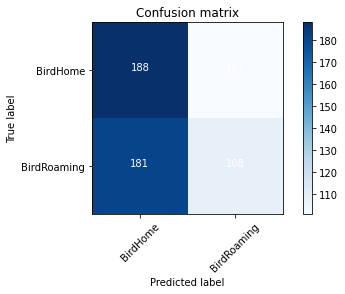

In [25]:
plot_confusion_matrix(cm, classes=["BirdHome", "BirdRoaming"])

Getting a strange mismatch here between training log and reported accuracies from model's predictions.